In [1]:
# import various libraries
from __future__ import absolute_import, division, print_function, unicode_literals

# load tensorflow extension into Jupyter
%load_ext tensorboard

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [35]:
# load data
#lfd = pd.read_csv("reduced.csv")
lfd = pd.read_csv("Procrustes_base.csv")

# replace values with dots or dashes (due to data label variants)
lfd.loc[(lfd['species'] == 'Vitis_sp.'), 'species'] = 'Vitis_sp'
lfd.loc[(lfd['species'] == 'Vitis_x_novae-angliae'), 'species'] = 'Vitis_x_novae_angliae'

In [3]:
# Visualize the data
print(lfd.loc[:,'species'].value_counts())

Vitis_riparia                  1971
Vitis_labrusca                  738
Vitis_cinerea                   618
Vitis_rupestris                 603
Vitis_acerifolia                381
Vitis_amurensis                 378
Vitis_sp                        342
Vitis_vulpina                   258
Vitis_aestivalis                168
Vitis_palmata                    66
Vitis_coignetiae                 60
Vitis_x_doaniana                 30
Vitis_x_andersonii               24
Vitis_x_novae_angliae            24
Ampelopsis_brevipedunculata      21
Vitis_x_champinii                18
Name: species, dtype: int64


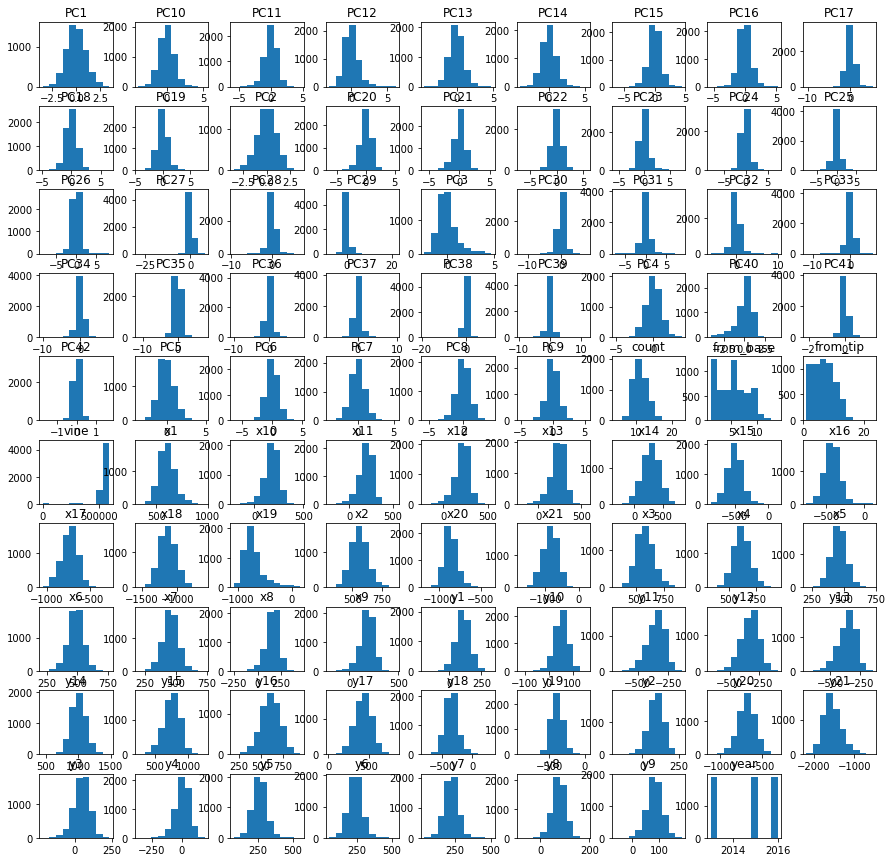

In [4]:
# make a histogram of our data to show distributions of values across the dataframe
histogram = lfd.hist(grid=False, bins=10, figsize=(15,15))

# x and y values look skewed normal. from_tip, from_base values look to be part of a modified uniform distribution.
# count values look skewed normal.

In [36]:
# print head of data
lfd.head()

,base_vine,vine,year,vine_year,species,from_tip,from_base,count,tip_vine,PC1,...,x17,y17,x18,y18,x19,y19,x20,y20,x21,y21
0,10x1583,1583,2013,1583x2013,Vitis_acerifolia,8,10,17,8x1583,-0.873498,...,-773.417167,530.360659,-1338.595312,-296.648911,-788.502868,-421.580330,-878.484789,-733.599371,-608.863391,-1612.438872
1,10x237621,237621,2013,237621x2013,Vitis_aestivalis,6,10,15,6x237621,0.542626,...,-725.211055,343.277655,-1028.649169,-398.067197,-729.232075,-398.355997,-911.901514,-677.709890,-1157.567630,-1652.086177
2,10x313922,313922,2013,313922x2013,Vitis_riparia,2,10,11,2x313922,1.274040,...,-589.139358,331.309077,-1035.774029,-448.443256,-715.676977,-300.604021,-865.491969,-611.708338,-1379.906517,-1614.081403
3,10x318684,318684,2013,318684x2013,Vitis_acerifolia,2,10,11,2x318684,0.634560,...,-717.318142,274.452196,-1178.749422,-518.663464,-794.905709,-317.480363,-897.419201,-587.381767,-1143.685860,-1598.494304
4,10x483138,483138,2013,483138x2013,Vitis_aestivalis,4,10,13,4x483138,-0.716141,...,-665.639109,478.490939,-1140.663125,-310.663543,-593.900401,-346.297023,-873.354059,-561.588170,-930.520913,-1909.580628


In [51]:
###########################################################################
# This code scales (does not normalize) data to be within the range [0,1]
# Neural networks work better when they utilize data within this range.
###########################################################################

# scale count, from_base, from_tip fields to ranges [0,1]
lfd.loc[:,'count']     /= lfd.loc[:,'count'].max()      # range [0,1]
lfd.loc[:,'from_base'] /= lfd.loc[:,'from_base'].max()  # range [0,1]
lfd.loc[:,'from_tip']  /= lfd.loc[:,'from_tip'].max()   # range [0,1]

# use generator function to get tuple of PC, x, y columns as strings
pc_cols = tuple('PC'+str(pc) for pc in range(1,43))
x_cols  = tuple('x'+str(x) for x in range(1,22))
y_cols  = tuple('y'+str(y) for y in range(1,22))

# scale PC values to range [0,1]
for PC in pc_cols:                               # for each PC{1..42} column
    pc_min = lfd.loc[:,PC].values.min()          # get min of column
    pc_div = lfd.loc[:,PC].values.max() - pc_min # get the difference between the max and min
    lfd.loc[:,PC] -= pc_min                      # scale min to 0
    lfd.loc[:,PC] /= pc_div                      # scale max to 1



# get a copy of x and y values
x_vals = lfd.loc[:,x_cols]
y_vals = lfd.loc[:,y_cols]

# calculate min, divisor for x values
x_min = x_vals.values.min()
x_div = x_vals.values.max() - x_min

# calculate min, divisor for y values
y_min = y_vals.values.min()
y_div = y_vals.values.max() - y_min

# scale x values to range [0,1]
lfd.loc[:,x_cols] -= x_min  # scale min to 0
lfd.loc[:,x_cols] /= x_div  # scale max to 1

# scale y values to range [0,1]
lfd.loc[:,y_cols] -= y_min  # scale min to 0
lfd.loc[:,y_cols] /= y_div  # scale max to 1

# print head of data
lfd.head()

,base_vine,vine,year,vine_year,species,from_tip,from_base,count,tip_vine,PC1,...,x17,y17,x18,y18,x19,y19,x20,y20,x21,y21
0,10x1583,1583,2013,1583x2013,Vitis_acerifolia,0.347826,0.714286,0.739130,8x1583,0.378357,...,0.362260,0.742001,0.155739,0.516595,0.356747,0.482545,0.323867,0.397502,0.422389,0.157971
1,10x237621,237621,2013,237621x2013,Vitis_aestivalis,0.260870,0.714286,0.652174,6x237621,0.580083,...,0.379874,0.691010,0.268996,0.488953,0.378405,0.488875,0.311656,0.412735,0.221888,0.147165
2,10x313922,313922,2013,313922x2013,Vitis_riparia,0.086957,0.714286,0.478261,2x313922,0.684273,...,0.429596,0.687748,0.266392,0.475223,0.383358,0.515517,0.328615,0.430724,0.140644,0.157523
3,10x318684,318684,2013,318684x2013,Vitis_acerifolia,0.086957,0.714286,0.478261,2x318684,0.593179,...,0.382759,0.672252,0.214148,0.456084,0.354408,0.510918,0.316948,0.437355,0.226961,0.161771
4,10x483138,483138,2013,483138x2013,Vitis_aestivalis,0.173913,0.714286,0.565217,4x483138,0.400772,...,0.401642,0.727863,0.228065,0.512776,0.427856,0.503064,0.325742,0.444385,0.304853,0.076983


In [52]:
# group data based on species
lfd_V_acerifolia       = lfd.loc[lfd['species'] == 'Vitis_acerifolia']
lfd_V_riparia          = lfd.loc[lfd['species'] == 'Vitis_riparia']
lfd_V_vulpina          = lfd.loc[lfd['species'] == 'Vitis_vulpina']
lfd_V_coignetiae       = lfd.loc[lfd['species'] == 'Vitis_coignetiae']
lfd_V_labrusca         = lfd.loc[lfd['species'] == 'Vitis_labrusca']
lfd_V_cinerea          = lfd.loc[lfd['species'] == 'Vitis_cinerea']
lfd_V_x_doaniana       = lfd.loc[lfd['species'] == 'Vitis_x_doaniana']
lfd_V_rupestris        = lfd.loc[lfd['species'] == 'Vitis_rupestris']
lfd_V_amurensis        = lfd.loc[lfd['species'] == 'Vitis_amurensis']
lfd_V_palmata          = lfd.loc[lfd['species'] == 'Vitis_palmata']
lfd_V_x_champinii      = lfd.loc[lfd['species'] == 'Vitis_x_champinii']
lfd_V_x_andersonii     = lfd.loc[lfd['species'] == 'Vitis_x_andersonii']
lfd_A_brevipedunculata = lfd.loc[lfd['species'] == 'Ampelopsis_brevipedunculata']
lfd_V_sp               = lfd.loc[lfd['species'] == 'Vitis_sp']
lfd_V_x_novae_angliae  = lfd.loc[lfd['species'] == 'Vitis_x_novae_angliae']

In [53]:
# shuffle data and get a fraction of the data
shuf_V_acerifolia       = lfd_V_acerifolia.sample(frac=1)
shuf_V_riparia          = lfd_V_riparia.sample(frac=1)
shuf_V_vulpina          = lfd_V_vulpina.sample(frac=1)
shuf_V_coignetiae       = lfd_V_coignetiae.sample(frac=1)
shuf_V_labrusca         = lfd_V_labrusca.sample(frac=1)
shuf_V_cinerea          = lfd_V_cinerea.sample(frac=1)
shuf_V_x_doaniana       = lfd_V_x_doaniana.sample(frac=1)
shuf_V_rupestris        = lfd_V_rupestris.sample(frac=1)
shuf_V_amurensis        = lfd_V_amurensis.sample(frac=1)
shuf_V_palmata          = lfd_V_palmata.sample(frac=1)
shuf_V_x_champinii      = lfd_V_x_champinii.sample(frac=1)
shuf_V_x_andersonii     = lfd_V_x_andersonii.sample(frac=1)
shuf_A_brevipedunculata = lfd_A_brevipedunculata.sample(frac=1)
shuf_V_sp               = lfd_V_sp.sample(frac=1)
shuf_V_x_novae_angliae  = lfd_V_x_novae_angliae.sample(frac=1)


In [54]:
import math

# sample top train_frac percent
train_frac = 0.8

# make training sets
train_V_acerifolia       = shuf_V_acerifolia.iloc[:int(math.ceil(len(shuf_V_acerifolia)*train_frac)),:]
train_V_riparia          = shuf_V_riparia.iloc[:int(math.ceil(len(shuf_V_riparia)*train_frac)),:]
train_V_vulpina          = shuf_V_vulpina.iloc[:int(math.ceil(len(shuf_V_vulpina)*train_frac)),:]
train_V_coignetiae       = shuf_V_coignetiae.iloc[:int(math.ceil(len(shuf_V_coignetiae)*train_frac)),:]
train_V_labrusca         = shuf_V_labrusca.iloc[:int(math.ceil(len(shuf_V_labrusca)*train_frac)),:]
train_V_cinerea          = shuf_V_cinerea.iloc[:int(math.ceil(len(shuf_V_cinerea)*train_frac)),:]
train_V_x_doaniana       = shuf_V_x_doaniana.iloc[:int(math.ceil(len(shuf_V_x_doaniana)*train_frac)),:]
train_V_rupestris        = shuf_V_rupestris.iloc[:int(math.ceil(len(shuf_V_rupestris)*train_frac)),:]
train_V_amurensis        = shuf_V_amurensis.iloc[:int(math.ceil(len(shuf_V_amurensis)*train_frac)),:]
train_V_palmata          = shuf_V_palmata.iloc[:int(math.ceil(len(shuf_V_palmata)*train_frac)),:]
train_V_x_champinii      = shuf_V_x_champinii.iloc[:int(math.ceil(len(shuf_V_x_champinii)*train_frac)),:]
train_V_x_andersonii     = shuf_V_x_andersonii.iloc[:int(math.ceil(len(shuf_V_x_andersonii)*train_frac)),:]
train_A_brevipedunculata = shuf_A_brevipedunculata.iloc[:int(math.ceil(len(shuf_A_brevipedunculata)*train_frac)),:]
train_V_sp               = shuf_V_sp.iloc[:int(math.ceil(len(shuf_V_sp)*train_frac)),:]
train_V_x_novae_angliae  = shuf_V_x_novae_angliae.iloc[:int(math.ceil(len(shuf_V_x_novae_angliae)*train_frac)),:]

# make testing sets
test_V_acerifolia       = shuf_V_acerifolia.iloc[int(math.ceil(len(shuf_V_acerifolia)*train_frac)):,:]
test_V_riparia          = shuf_V_riparia.iloc[int(math.ceil(len(shuf_V_riparia)*train_frac)):,:]
test_V_vulpina          = shuf_V_vulpina.iloc[int(math.ceil(len(shuf_V_vulpina)*train_frac)):,:]
test_V_coignetiae       = shuf_V_coignetiae.iloc[int(math.ceil(len(shuf_V_coignetiae)*train_frac)):,:]
test_V_labrusca         = shuf_V_labrusca.iloc[int(math.ceil(len(shuf_V_labrusca)*train_frac)):,:]
test_V_cinerea          = shuf_V_cinerea.iloc[int(math.ceil(len(shuf_V_cinerea)*train_frac)):,:]
test_V_x_doaniana       = shuf_V_x_doaniana.iloc[int(math.ceil(len(shuf_V_x_doaniana)*train_frac)):,:]
test_V_rupestris        = shuf_V_rupestris.iloc[int(math.ceil(len(shuf_V_rupestris)*train_frac)):,:]
test_V_amurensis        = shuf_V_amurensis.iloc[int(math.ceil(len(shuf_V_amurensis)*train_frac)):,:]
test_V_palmata          = shuf_V_palmata.iloc[int(math.ceil(len(shuf_V_palmata)*train_frac)):,:]
test_V_x_champinii      = shuf_V_x_champinii.iloc[int(math.ceil(len(shuf_V_x_champinii)*train_frac)):,:]
test_V_x_andersonii     = shuf_V_x_andersonii.iloc[int(math.ceil(len(shuf_V_x_andersonii)*train_frac)):,:]
test_A_brevipedunculata = shuf_A_brevipedunculata.iloc[int(math.ceil(len(shuf_A_brevipedunculata)*train_frac)):,:]
test_V_sp               = shuf_V_sp.iloc[int(math.ceil(len(shuf_V_sp)*train_frac)):,:]
test_V_x_novae_angliae  = shuf_V_x_novae_angliae.iloc[int(math.ceil(len(shuf_V_x_novae_angliae)*train_frac)):,:]


In [55]:
# combine all training and testing sets
train_df_list = [train_V_acerifolia,       train_V_riparia, train_V_vulpina,        train_V_coignetiae, 
                 train_V_labrusca,         train_V_cinerea, train_V_x_doaniana,     train_V_rupestris,
                 train_V_amurensis,        train_V_palmata, train_V_x_champinii,    train_V_x_andersonii,
                 train_A_brevipedunculata, train_V_sp,      train_V_x_novae_angliae]

test_df_list = [test_V_acerifolia,       test_V_riparia, test_V_vulpina,        test_V_coignetiae, 
                test_V_labrusca,         test_V_cinerea, test_V_x_doaniana,     test_V_rupestris,
                test_V_amurensis,        test_V_palmata, test_V_x_champinii,    test_V_x_andersonii,
                test_A_brevipedunculata, test_V_sp,      test_V_x_novae_angliae]

train_df = pd.concat(train_df_list, ignore_index=True)
test_df = pd.concat(test_df_list, ignore_index=True)

train_df.head()

,base_vine,vine,year,vine_year,species,from_tip,from_base,count,tip_vine,PC1,...,x17,y17,x18,y18,x19,y19,x20,y20,x21,y21
0,2x588324,588324,2013,588324x2013,Vitis_acerifolia,0.521739,0.142857,0.565217,12x588324,0.791294,...,0.314198,0.684909,0.290070,0.491663,0.466010,0.495009,0.359945,0.434671,0.319340,0.348786
1,2x588459,588459,2016,588459x2016,Vitis_acerifolia,0.434783,0.142857,0.478261,10x588459,0.440141,...,0.334293,0.746708,0.200846,0.518026,0.400745,0.499065,0.372638,0.385100,0.427678,0.197934
2,4x588144,588144,2013,588144x2013,Vitis_acerifolia,0.391304,0.285714,0.521739,9x588144,0.588323,...,0.341454,0.710492,0.206288,0.497608,0.444333,0.500099,0.318659,0.410711,0.296809,0.200765
3,4x588144,588144,2015,588144x2015,Vitis_acerifolia,0.391304,0.285714,0.521739,9x588144,0.753445,...,0.381399,0.665240,0.258881,0.509912,0.417790,0.488302,0.314981,0.417795,0.250751,0.236570
4,7x588442,588442,2016,588442x2016,Vitis_acerifolia,0.304348,0.500000,0.565217,7x588442,0.563393,...,0.369406,0.701413,0.239089,0.495336,0.399337,0.488347,0.337014,0.417415,0.259049,0.165559


In [42]:
print((1,2,(3,4)))

(1, 2, (3, 4))


In [65]:
# select data we're using for the NN

# concatenate selected tuples together
cols = ('from_tip','from_base','count') + pc_cols + x_cols + y_cols

# get matrix of columns
train_numpy = train_df.loc[:,cols].to_numpy()
test_numpy  = test_df.loc[:,cols].to_numpy()

In [66]:
# get a one-hot encoding (OHE) matrix for train and test sets
train_OHE_numpy = pd.get_dummies(train_df.loc[:,'species'], prefix='OHE').to_numpy()
test_OHE_numpy = pd.get_dummies(test_df.loc[:,'species'], prefix='OHE').to_numpy()
# NOTE: if dummy values are assigned differently, then there will be major problems

# encode strings as integers
#sp_list = list(lfd['species'].unique())
#sp_dict = dict(zip(sp_list, list(range(len(sp_list)))))

#print(sp_dict)

#train_cat_numpy = train_df['species'].replace(sp_dict).to_numpy()
#test_cat_numpy = test_df['species'].replace(sp_dict).to_numpy()
train_OHE_numpy.shape[1]

15

In [76]:
####################################
# machine learning: neural network #
####################################

# specify NN format
model = keras.Sequential([
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(192, activation='relu'),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(96, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(train_OHE_numpy.shape[1], activation='softmax') # 15 categories, so reduce to 15 nodes
])

# compile NN model
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# train model and record training history
model_thist = model.fit(train_numpy,
                        train_OHE_numpy,
                        epochs=60,
                        #batch_size=1024,
                        validation_data=(test_numpy, test_OHE_numpy),
                        verbose=2)

Train on 4432 samples, validate on 1100 samples
Epoch 1/60
4432/4432 - 1s - loss: 2.0627 - accuracy: 0.3500 - val_loss: 1.9716 - val_accuracy: 0.3582
Epoch 2/60
4432/4432 - 0s - loss: 1.9334 - accuracy: 0.3646 - val_loss: 1.7293 - val_accuracy: 0.4345
Epoch 3/60
4432/4432 - 0s - loss: 1.7731 - accuracy: 0.4262 - val_loss: 1.9701 - val_accuracy: 0.3064
Epoch 4/60
4432/4432 - 0s - loss: 1.6661 - accuracy: 0.4673 - val_loss: 1.9566 - val_accuracy: 0.4191
Epoch 5/60
4432/4432 - 0s - loss: 1.6018 - accuracy: 0.4907 - val_loss: 1.6575 - val_accuracy: 0.4600
Epoch 6/60
4432/4432 - 0s - loss: 1.5324 - accuracy: 0.5165 - val_loss: 1.5179 - val_accuracy: 0.5291
Epoch 7/60
4432/4432 - 0s - loss: 1.4899 - accuracy: 0.5255 - val_loss: 1.5058 - val_accuracy: 0.5073
Epoch 8/60
4432/4432 - 0s - loss: 1.4437 - accuracy: 0.5408 - val_loss: 1.3148 - val_accuracy: 0.5736
Epoch 9/60
4432/4432 - 0s - loss: 1.4015 - accuracy: 0.5451 - val_loss: 1.3147 - val_accuracy: 0.5827
Epoch 10/60
4432/4432 - 0s - loss:

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


Text(0.5, 1.0, 'Model accuracy (red), Validation accuracy (blue), Loss (pink), Validation loss (green)')

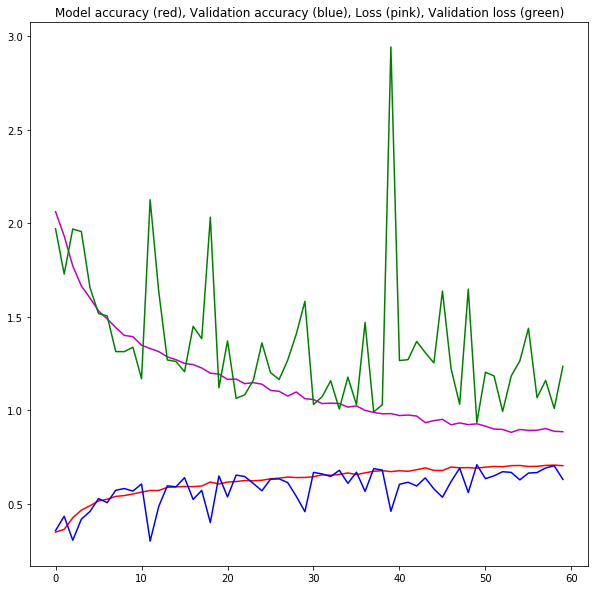

In [77]:
import matplotlib.pyplot as plt
%matplotlib inline

print(model_thist.history.keys())
#print(model_thist.history)


plt.figure(figsize=(10,10))
plt.plot(model_thist.epoch, model_thist.history['accuracy'], color='r')
plt.plot(model_thist.epoch, model_thist.history['val_accuracy'], color='b')
plt.plot(model_thist.epoch, model_thist.history['loss'], color='m')
plt.plot(model_thist.epoch, model_thist.history['val_loss'], color='g')
plt.title('Model accuracy (red), Validation accuracy (blue), Loss (pink), Validation loss (green)')

# 60 is probably the necessary number of epochs

In [91]:
# make prediction on the test entries
model_pred = model.predict(test_numpy)

# get prediction indices
pred_index = np.argmax(model_pred, axis=1)

# get one-hot indices
test_index = np.argmax(test_OHE_numpy, axis=1)

# calculate the confusion matrix
conf_mat = tf.math.confusion_matrix(test_index, pred_index)

print(conf_mat)

tf.Tensor(
[[  4   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0  22   3   1   0   0   0  25  25   0   0   0   0   0   0]
 [  0   0  54   1   0   1   0  11   2   0   6   0   0   0   0]
 [  0   0   8  64   0  15   2   7   4   3  20   0   0   0   0]
 [  0   0   6   2   0   2   0   0   0   0   2   0   0   0   0]
 [  0   2  17   6   0  89   1   5  10   2  15   0   0   0   0]
 [  0   0   0   0   0   0   7   0   6   0   0   0   0   0   0]
 [  0  25   3   0   0   5   2 292  53   0  11   0   0   3   0]
 [  0   2   0   0   0   0   0   4 111   0   3   0   0   0   0]
 [  3   3   0   3   0   9   0  15   8  13  14   0   0   0   0]
 [  0   0   1   3   0   0   1   5   2   0  39   0   0   0   0]
 [  0   0   1   0   0   0   1   2   0   0   0   0   0   0   0]
 [  0   0   0   0   0   1   0   0   0   0   2   0   0   0   0]
 [  0   0   0   0   0   0   0   3   3   0   0   0   0   0   0]
 [  0   0   0   0   0   2   0   0   0   0   2   0   0   0   0]], shape=(15, 15), dtype=int32)


In [99]:
# ruthlessly stolen from: https://www.tensorflow.org/tensorboard/image_summaries

import itertools

def plot_confusion_matrix(cm, class_names):
  """
  Returns a matplotlib figure containing the plotted confusion matrix.

  Args:
    cm (array, shape = [n, n]): a confusion matrix of integer classes
    class_names (array, shape = [n]): String names of the integer classes
  """
  figure = plt.figure(figsize=(8, 8))
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  plt.title("Confusion matrix")
  plt.colorbar()
  tick_marks = np.arange(len(class_names))
  plt.xticks(tick_marks, class_names, rotation=45)
  plt.yticks(tick_marks, class_names)

  # Normalize the confusion matrix.
  cm = tf.cast(cm, 'float32')
  cm = np.around(cm / tf.math.reduce_sum(cm,axis=1)[:, np.newaxis], decimals=2)

  # Use white text if squares are dark; otherwise black.
  threshold = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    color = "white" if cm[i, j] > threshold else "black"
    plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  return figure

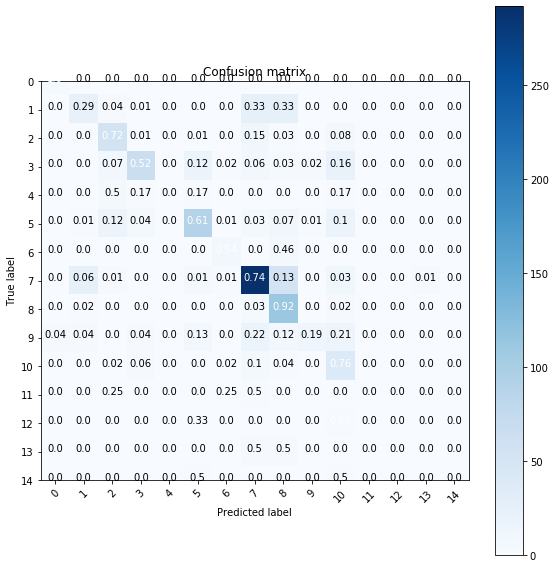

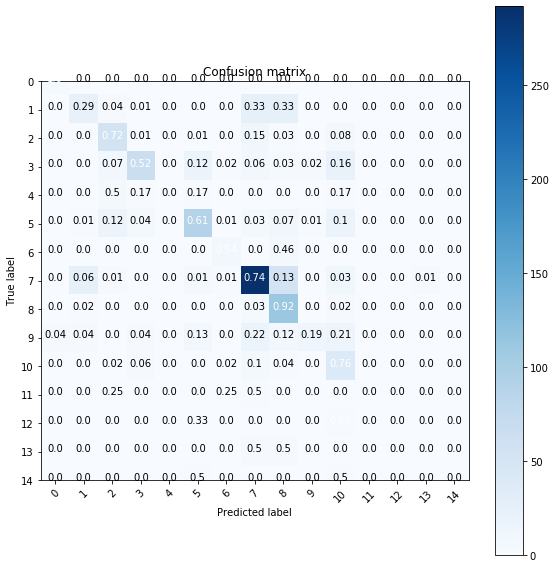

In [100]:
plot_confusion_matrix(conf_mat, [str(x) for x in range(0,15)])